# Exploration of PCA and POD on Sentinel-2 Data for Surface Melt Estimation

## Gabrielle Hobson
## SIO 236 Term Paper Project

### Loading and Packing Data

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
#from PIL import Image
import rasterio
from time import perf_counter

# open data using rasterio
b4_data = rasterio.open('/Users/ghobson/Documents/Spring_2021/236/Term_Paper/Data/R10m/T42DVF_20190102T041719_B04_10m.jp2')
b3_data = rasterio.open('/Users/ghobson/Documents/Spring_2021/236/Term_Paper/Data/R10m/T42DVF_20190102T041719_B03_10m.jp2')
b2_data = rasterio.open('/Users/ghobson/Documents/Spring_2021/236/Term_Paper/Data/R10m/T42DVF_20190102T041719_B02_10m.jp2')
'''
print(b4_data.width)
print(b4_data.height)
print({i: dtype for i, dtype in zip(b4_data.indexes, b4_data.dtypes)})
print(b4_data.bounds)
print(b4_data.transform)
'''
# using rasterio, read data in numpy arrays that we can work with 
band4 = b4_data.read(1)
band3 = b3_data.read(1)
band2 = b2_data.read(1)

# get smaller subset to make SVD easier
band4 = band4[4570:8420,4612:8120]
band3 = band3[4570:8420,4612:8120]
band2 = band2[4570:8420,4612:8120]

# center the data
band4 = band4 - np.mean(np.mean(band4))
band3 = band3 - np.mean(np.mean(band3))
band2 = band2 - np.mean(np.mean(band2))

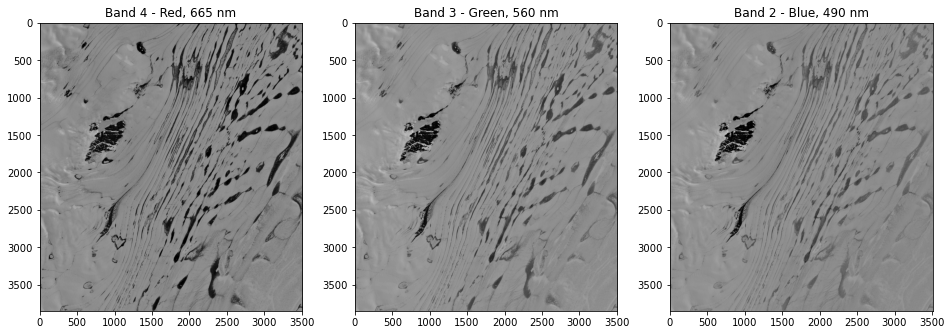

In [4]:
# plotting the rgb bands
plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.imshow(band4,cmap=cm.gray)
plt.title('Band 4 - Red, 665 nm')
plt.subplot(1,3,2)
plt.imshow(band3,cmap=cm.gray)
plt.title('Band 3 - Green, 560 nm')
plt.subplot(1,3,3)
plt.imshow(band2,cmap=cm.gray)
plt.title('Band 2 - Blue, 490 nm')
plt.show()

In [6]:
# pack data into vertical array
arr = np.vstack((band4.reshape(-1),band3.reshape(-1),band2.reshape(-1))).T
print(np.shape(arr))

(13505800, 3)


### POD method on tall, skinny array

In [7]:
print('starting svd')
t1 = perf_counter()
U,S,Vt = linalg.svd(arr,full_matrices=0)
t2 = perf_counter()
print('svd done in ', t2-t1)
print(np.shape(U))
print(np.shape(S))
print(np.shape(Vt))

starting svd
svd done in  0.6733313429999725
(13505800, 3)
(3,)
(3, 3)


In [8]:
print('first 3 sing vals')
print(S[:3])

first 3 sing vals
[10282580.70988221  1896323.08794276   345508.20684159]


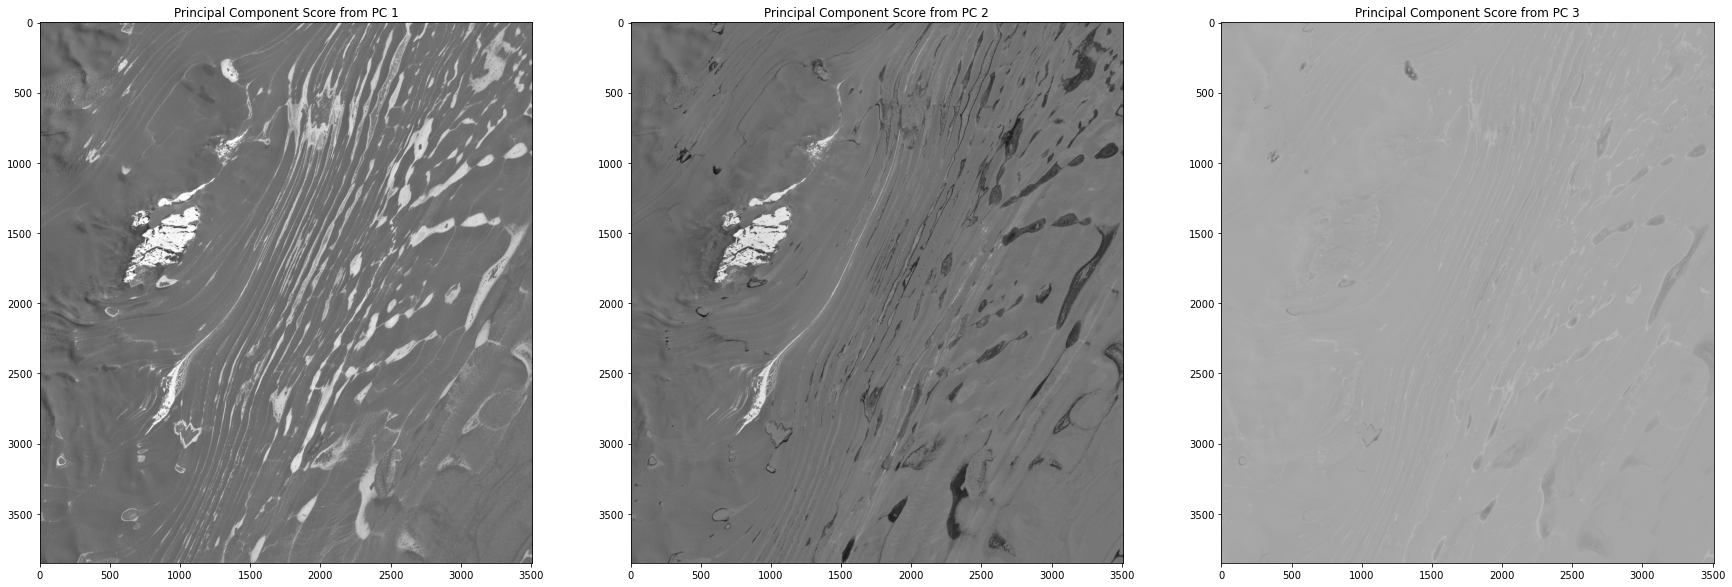

In [9]:
# creating equivalent to PC scores from POD results

# create a 3D data array that we will scale by the right singular vectors to get PC scores 
# (but using POD/SVD singular vectors)
a=np.zeros([np.shape(band4)[0],np.shape(band4)[1],3]);
a[:,:,0]=band4
a[:,:,1]=band3
a[:,:,2]=band2

V = np.transpose(Vt)
P = np.zeros([np.shape(band4)[0],np.shape(band4)[1],3]);
for i in np.arange(0,3): # loop over bands
    for j in np.arange(0,3): # loop over eigenvectors
        P[:,:,j] = P[:,:,j] + V[i,j]*a[:,:,i]

# visualizing first three PC scores
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.imshow(P[:,:,0],cmap=cm.gray)
plt.title('Principal Component Score from PC 1')
plt.subplot(132)
plt.imshow(P[:,:,1],cmap=cm.gray)
plt.title('Principal Component Score from PC 2')
plt.subplot(133)
plt.imshow(P[:,:,2],cmap=cm.gray)
plt.title('Principal Component Score from PC 3')
plt.show()

In [10]:
# quick orthogonality check
V[1,:] = -V[1,:]
V[2,:] = -V[2,:]
Vt[1,:] = -Vt[1,:]
Vt[2,:] = -Vt[2,:]
Vt @ V

array([[ 1.00000000e+00,  1.14763652e-16, -9.26694502e-17],
       [ 1.14763652e-16,  1.00000000e+00, -3.10130765e-17],
       [-9.26694502e-17, -3.10130765e-17,  1.00000000e+00]])

# POD for Image Compression

In [2]:
arr_lr = np.vstack((band4,band3,band2))
    
print('starting svd')
t1 = perf_counter()
U,S,Vt = linalg.svd(arr_lr,full_matrices=1)
t2 = perf_counter()
print('svd done in ', t2-t1)
print(np.shape(U))
print(np.shape(S))
print(np.shape(Vt))

starting svd
svd done in  27.241144387000002
(11550, 11550)
(3508,)
(3508, 3508)


In [18]:
lr = np.zeros(arr_lr.shape)
for k in range(350):
    u_col = U[:,k]
    v_col = Vt[k,:]
    sing = S[k]
    lr += sing*np.outer(u_col,v_col)
lr_red = lr[0:3850,:]
lr_green = lr[3850:2*3850,:]
lr_blue = lr[2*3850:3*3850,:]

In [26]:
frac_var = np.sum(S[0:800]**2)/np.sum(S[0:3508]**2)
#print(S[0:100])
#print(S[0:100]**2)
print(frac_var)

0.9869171511126775


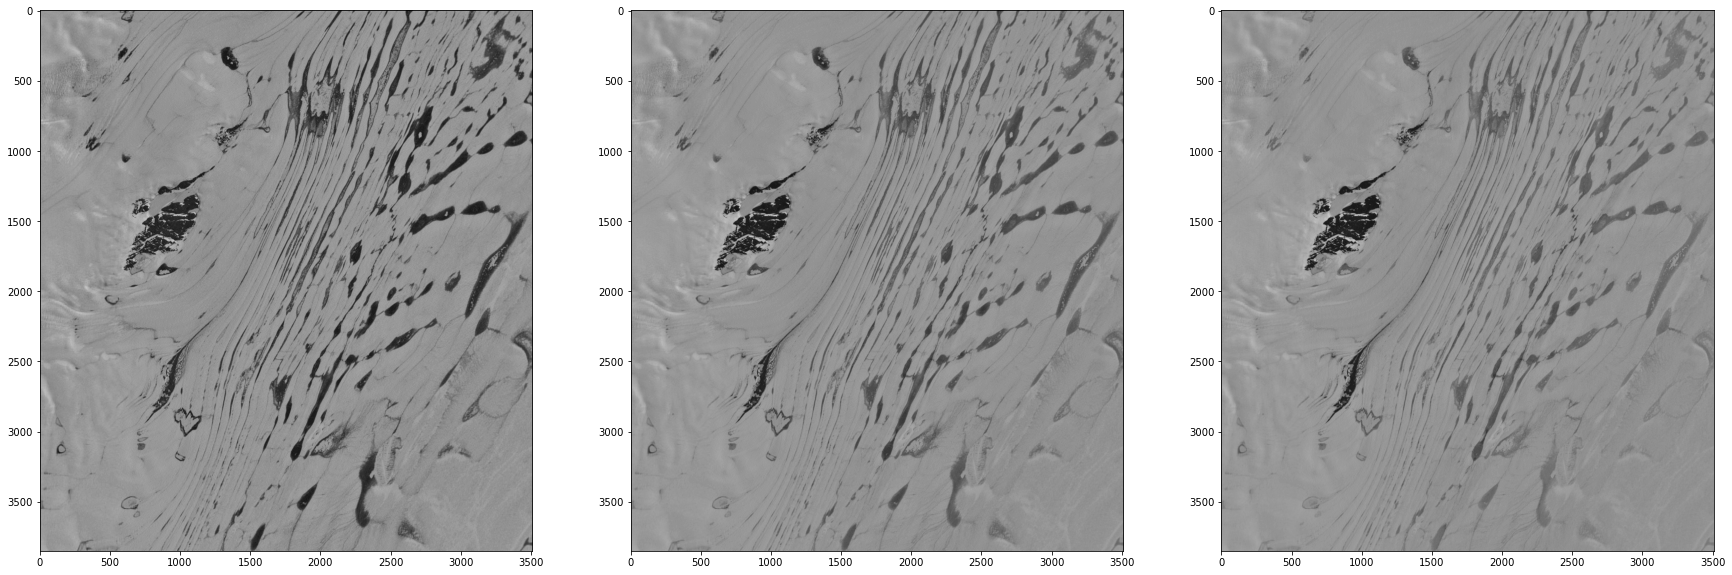

In [19]:
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(lr_red,cmap=cm.gray)
#plt.title('LR - Red, 665 nm')
plt.subplot(1,3,2)
plt.imshow(lr_green,cmap=cm.gray)
#plt.title('LR - Green, 560 nm')
plt.subplot(1,3,3)
plt.imshow(lr_blue,cmap=cm.gray)
#plt.title('LR - Blue, 490 nm')
plt.show()

# PCA on all 13 bands 

In [3]:
AOT_data = rasterio.open('/Users/ghobson/Documents/Spring_2021/236/Term_Paper/Data/R20m/T42DVF_20190102T041719_AOT_20m.jp2')
b2_data = rasterio.open('/Users/ghobson/Documents/Spring_2021/236/Term_Paper/Data/R20m/T42DVF_20190102T041719_B02_20m.jp2')
b3_data = rasterio.open('/Users/ghobson/Documents/Spring_2021/236/Term_Paper/Data/R20m/T42DVF_20190102T041719_B03_20m.jp2')
b4_data = rasterio.open('/Users/ghobson/Documents/Spring_2021/236/Term_Paper/Data/R20m/T42DVF_20190102T041719_B04_20m.jp2')
b5_data = rasterio.open('/Users/ghobson/Documents/Spring_2021/236/Term_Paper/Data/R20m/T42DVF_20190102T041719_B05_20m.jp2')
b6_data = rasterio.open('/Users/ghobson/Documents/Spring_2021/236/Term_Paper/Data/R20m/T42DVF_20190102T041719_B06_20m.jp2')
b7_data = rasterio.open('/Users/ghobson/Documents/Spring_2021/236/Term_Paper/Data/R20m/T42DVF_20190102T041719_B07_20m.jp2')
b8A_data = rasterio.open('/Users/ghobson/Documents/Spring_2021/236/Term_Paper/Data/R20m/T42DVF_20190102T041719_B8A_20m.jp2')
b11_data = rasterio.open('/Users/ghobson/Documents/Spring_2021/236/Term_Paper/Data/R20m/T42DVF_20190102T041719_B11_20m.jp2')
b12_data = rasterio.open('/Users/ghobson/Documents/Spring_2021/236/Term_Paper/Data/R20m/T42DVF_20190102T041719_B12_20m.jp2')
SCL_data = rasterio.open('/Users/ghobson/Documents/Spring_2021/236/Term_Paper/Data/R20m/T42DVF_20190102T041719_SCL_20m.jp2')
TCI_data = rasterio.open('/Users/ghobson/Documents/Spring_2021/236/Term_Paper/Data/R20m/T42DVF_20190102T041719_TCI_20m.jp2')
WVP_data = rasterio.open('/Users/ghobson/Documents/Spring_2021/236/Term_Paper/Data/R20m/T42DVF_20190102T041719_WVP_20m.jp2')

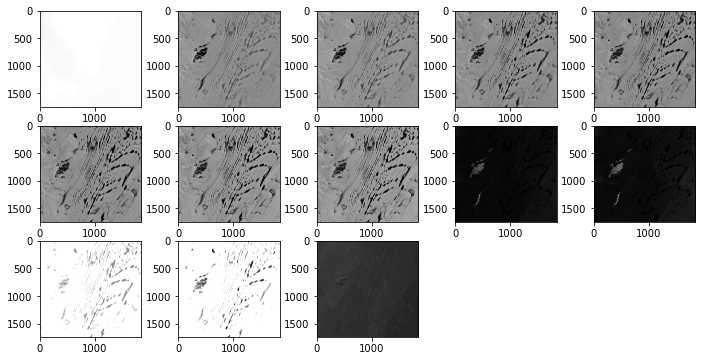

In [4]:
data = np.zeros((b4_data.height,b4_data.width,13))
data[:,:,0] = AOT_data.read(1)
data[:,:,1] = b2_data.read(1)
data[:,:,2] = b3_data.read(1)
data[:,:,3] = b4_data.read(1)
data[:,:,4] = b5_data.read(1)
data[:,:,5] = b6_data.read(1)
data[:,:,6] = b7_data.read(1)
data[:,:,7] = b8A_data.read(1)
data[:,:,8] = b11_data.read(1)
data[:,:,9] = b12_data.read(1)
data[:,:,10] = SCL_data.read(1)
data[:,:,11] = TCI_data.read(1)
data[:,:,12] = WVP_data.read(1)

# get smaller subset to focus in on area of interest
data_new = np.zeros((4020-2280,4180-2343,13))
for i in range((13)):
    data_new[:,:,i] = data[2280:4020,2343:4180,i] 
data = data_new

plt.figure(figsize=(12,6))
for i in range((13)):
    plt.subplot(3,5,i+1)
    plt.imshow(data[:,:,i],cmap=cm.gray)

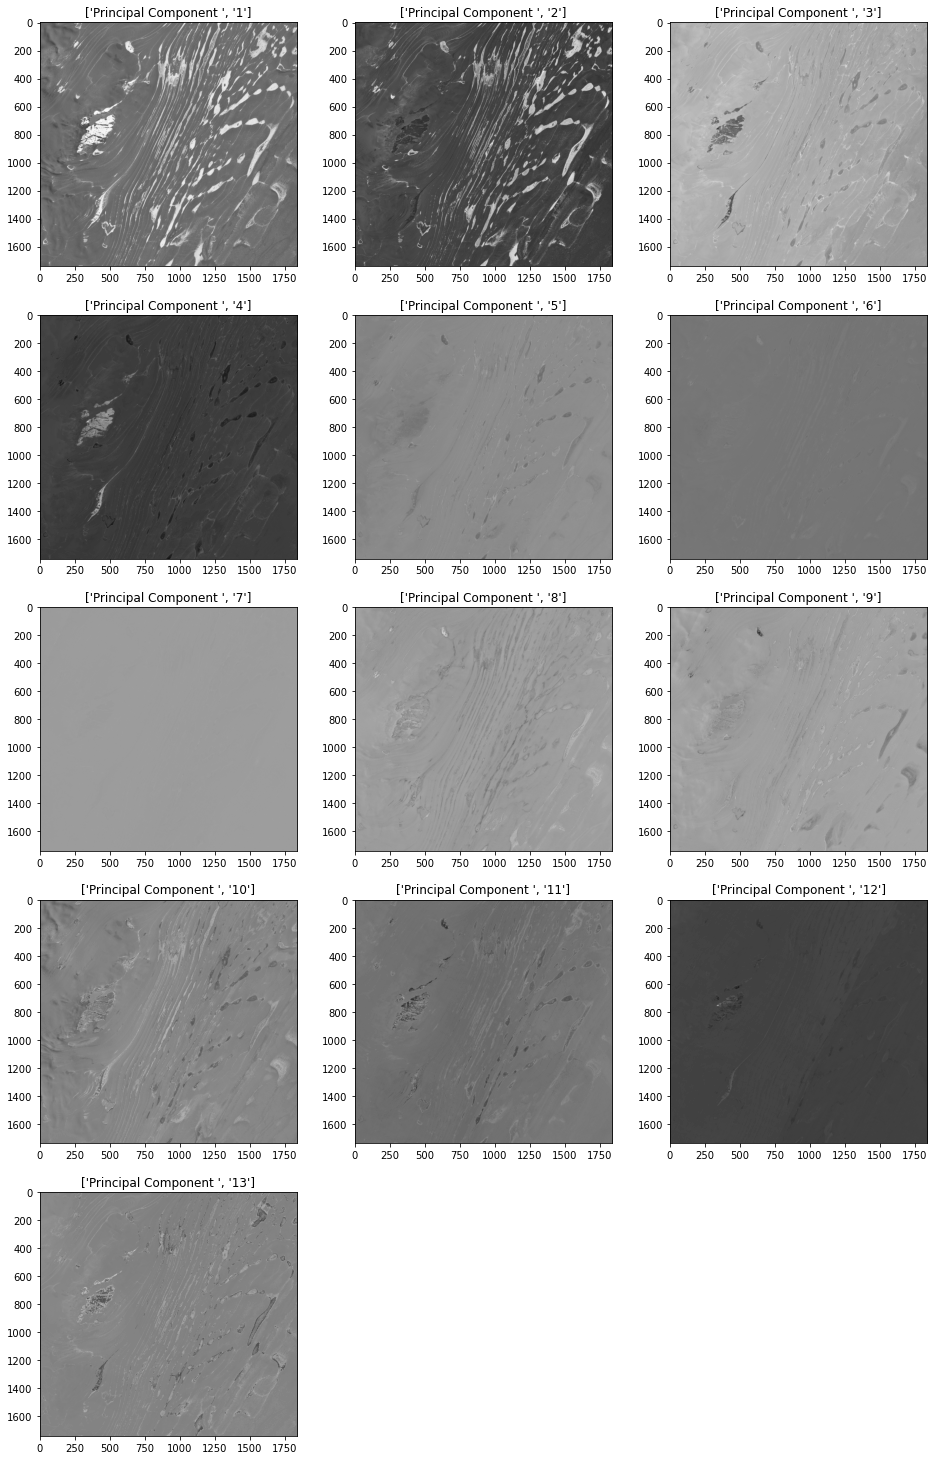

In [5]:
# computing covariance matrix
C = np.zeros((np.shape(data)[2],np.shape(data)[2]))
for i in np.arange(0,np.shape(data)[2]):
    for j in np.arange(0,np.shape(data)[2]):
        C[i,j] = np.mean(np.mean(data[:,:,i]*data[:,:,j]))
        
# computing eigenvalues and eigenvectors
[D,V] = np.linalg.eig(C)

# creating principal components
P = np.zeros([np.shape(data)[0],np.shape(data)[1],np.shape(data)[2]]);
for i in np.arange(0,np.shape(data)[2]):
    for j in np.arange(0,np.shape(data)[2]):
        P[:,:,j] = P[:,:,j] + V[i,j]*data[:,:,i]

# visualizing
plt.figure(figsize=(16,26))
for i in range((np.shape(data)[2])):
    plt.subplot(5,3,i+1)
    plt.imshow(P[:,:,i],cmap=cm.gray,vmin=np.min(np.min(P[:,:,i])),vmax=np.max(np.max(P[:,:,i])))
    plt.title(['Principal Component ',str(i+1)])

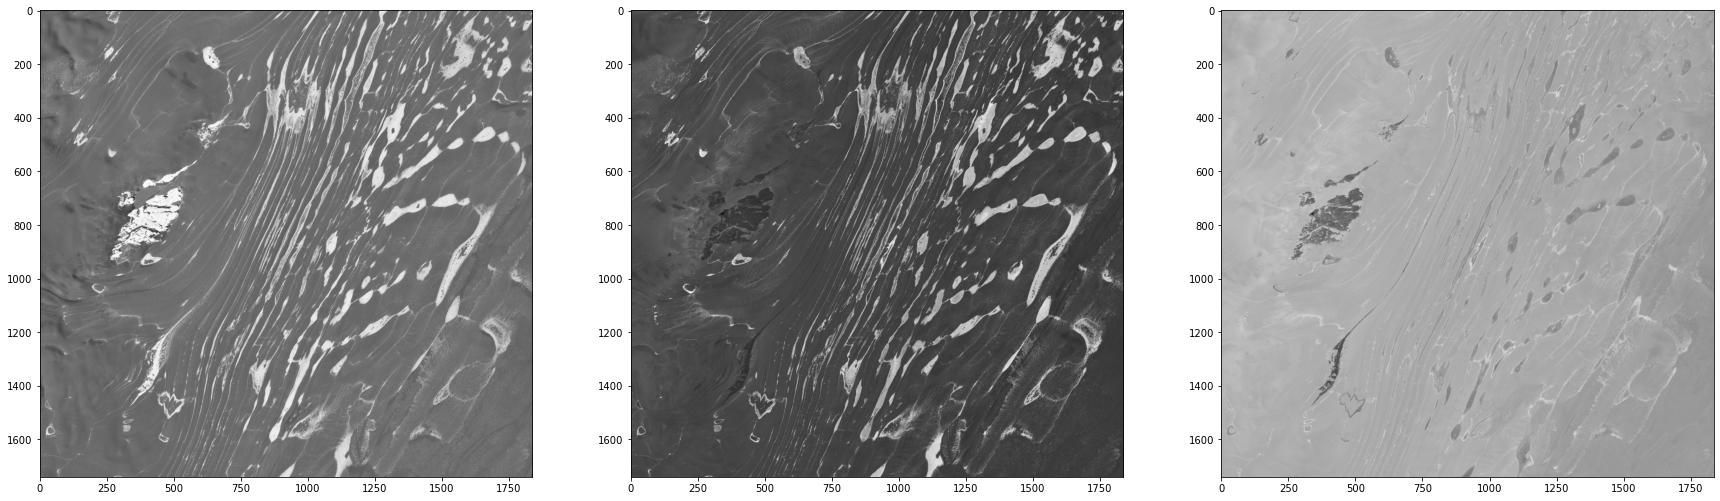

In [7]:
plt.figure(figsize=(30,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(P[:,:,i],cmap=cm.gray,vmin=np.min(np.min(P[:,:,i])),vmax=np.max(np.max(P[:,:,i])))
  #plt.title(['Principal Component ',str(i+1)])